# Statement

Insurance company wants to solve several tasks with the help of Machine Learning.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task.

# Data Preprocessing & Exploration

## Initialization

In [2]:
import numpy as np
import pandas as pd
import math
import sidetable as stb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
try:
    df = pd.read_csv('insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
605,1,31.0,52000.0,2,0
4104,0,22.0,48600.0,1,0
3039,1,21.0,22600.0,2,0
4993,1,32.0,36000.0,1,0
3336,1,24.0,36500.0,3,0
97,1,23.0,31500.0,1,0
4939,0,28.0,30400.0,0,0
1001,1,32.0,29700.0,2,0
987,0,26.0,41000.0,0,0
4076,0,34.0,39300.0,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


The conversion was done successfully.

In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

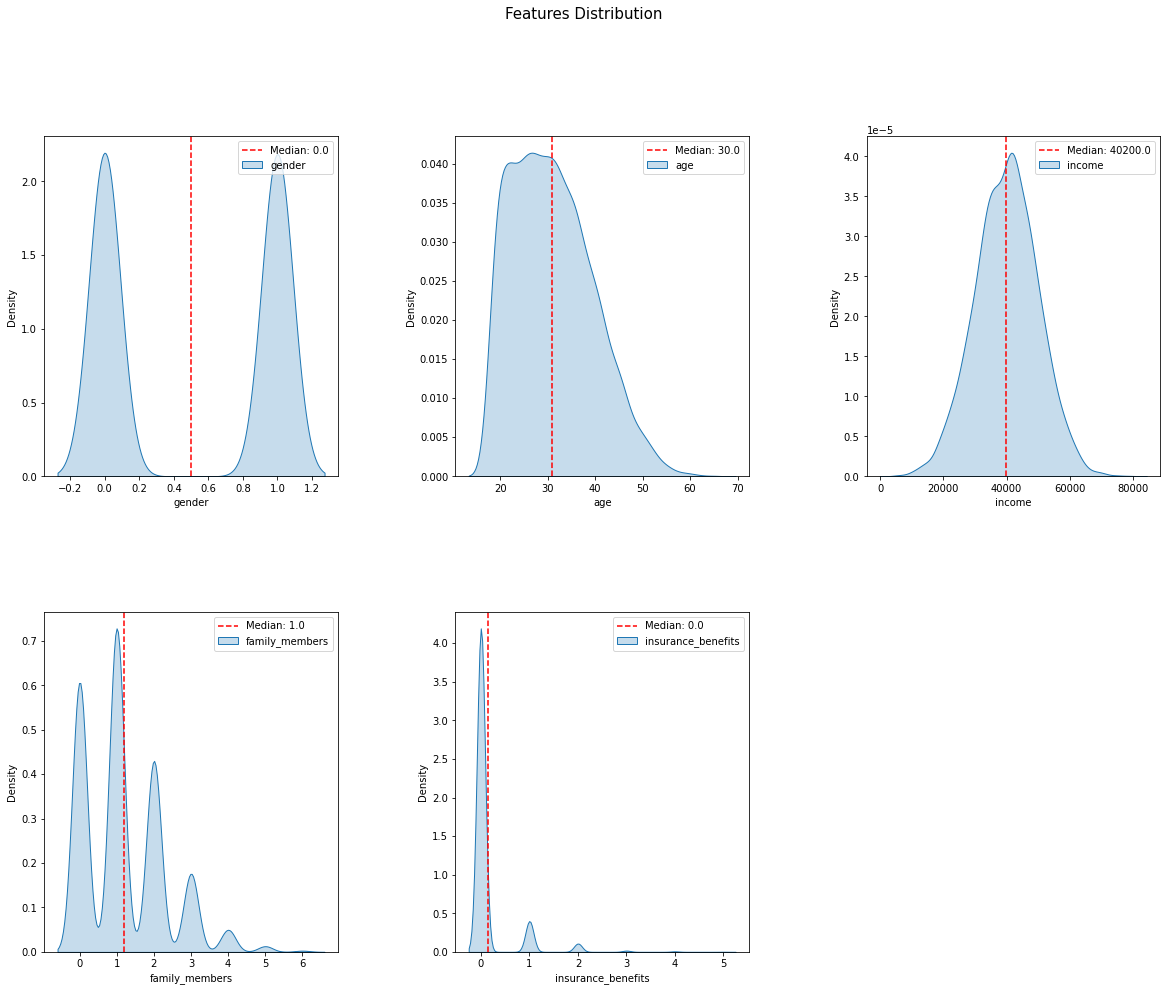

In [10]:
col = df.columns
fig = plt.figure(figsize =(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Features Distribution', fontsize=15, y=1)
for i in range(1, len(col)+1):
    m = str(df[col[i-1]].median())
    ax = fig.add_subplot(2, 3, i)
    sns.kdeplot(df[col[i -1 ]], fill=True, label=col[i -1])
    plt.axvline(x = df[col[i-1]].mean(),
            color='red',
            ls='--', 
            lw=1.5,
            label= 'Median:' + ' ' + m)
    plt.legend(fontsize=10)
    plt.ylabel('Density', fontsize=10)

The average customer is a woman or a man, at age 30 with an income of 40,000, married/in a relationship and 0 insurance benefits. Also,  we see that all variables, except gender, have few outliers. For example:
* **age** - The plot has a tail to the left, which means that probably some customers are significantly older than most of the customers. 
* **income** - The income feature has an almost perfect normal distribution. We can see in the plot that this feature has tails both from the right and from the left. Therefore there are probably customers whose income is much smaller or much greater than the average customer income.
* **family_members** - We see in the plot that this feature has a relatively long tail, which implies that there are some customers with much greater families than the average customer.
* **insurance_benafits** - The plot tells us that there is a long tail to the right, which implies that there is a small number of customers that got a great number of insurance benefits as opposed to most customers.

Let's check for outliers.

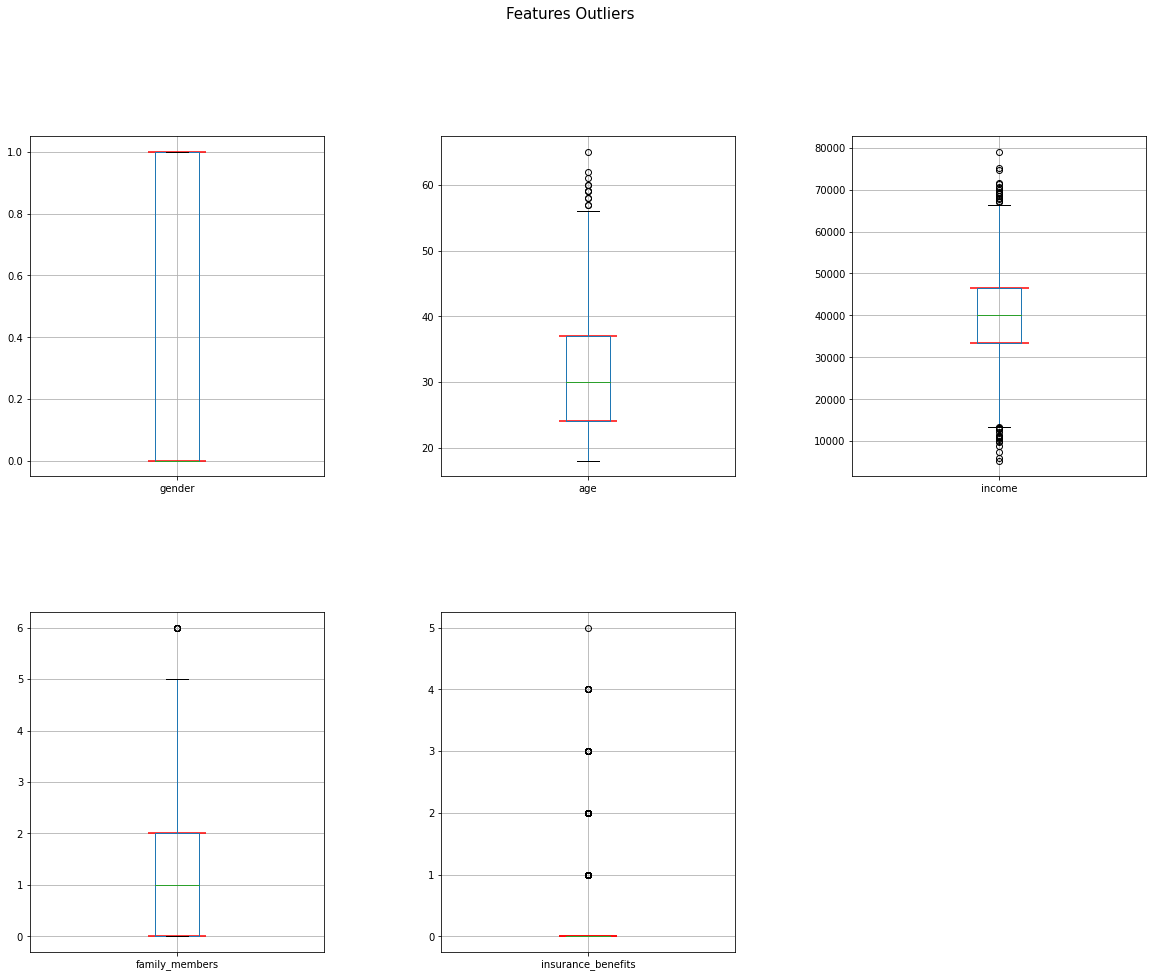

In [11]:
col = df.columns
fig = plt.figure(figsize =(20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Features Outliers', fontsize=15, y=1)
for i in range(1,len(col)+1):
    ax = fig.add_subplot(2, 3, i)
    df.boxplot(col[i-1])
    Q1 = df[col[i-1]].quantile(0.25)
    Q3 = df[col[i-1]].quantile(0.75)
    plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')

As we mentioned earlier most of the features have outliers. All the values of the target variable that are greater than 0 are mentioned as outliers. Let's check the amount of each value with the value_counts() method before removing the outliers. Because it is our target variable, if we will delete all the outliers that were mentioned in the box plot, we will stay only with the value 0 in the target variable. So before deciding how to act, we need to check it more thoroughly.

In [12]:
df.insurance_benefits.value_counts() / len(df)

0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: insurance_benefits, dtype: float64

We see that 88% present of our data has 0 insurance benefits, which means that the other values have a small share in the dataset. Yet, it's the target variable, so deleting all the outliers will leave us only with the value 0 in the target variable, which will decrease the learning ability. **We will delete the outliers of all the features, except the target variable**. We will see if this process will delete also some of the target variable outliers.

**Outliers Removal**

In [13]:
# Building a function for outlier removal
def outlier_removal(data, original_data):
    col = data.columns
    for i in range(len(col)):
        
        # Finding the range of quantiles Q1 and Q3
        q1 = data[col[i]].quantile(0.25)
        q3 = data[col[i]].quantile(0.75)
        iqr = q3 - q1
        box_max_0 = math.floor(q3 + 1.5*iqr)
        box_min_0 = math.ceil(q1 - 1.5*iqr)
        
        # Removing the values that exceed the quantiles range
        data.drop(data[(data[col[i]] > box_max_0) | (data[col[i]] < box_min_0)].index, inplace = True)
        
        # Removing outliers from the original dataset
        original_data.drop(original_data[(original_data[col[i]] > box_max_0) | 
                                         (original_data[col[i]] < box_min_0)].index, inplace = True)
        
        # Checking if there is 'new' outliers and removing them
        q1 = data[col[i]].quantile(0.25)
        q3 = data[col[i]].quantile(0.75)
        iqr = q3 - q1
        box_max_new = math.floor(q3 + 1.5*iqr)
        box_min_new = math.ceil(q1 - 1.5*iqr)
        
        while box_max_new < box_max_0:
            data.drop(data[(data[col[i]] > box_max_new) | (data[col[i]] < box_min_new)].index, inplace = True)
            original_data.drop(original_data[(original_data[col[i]] > box_max_new) | 
                                         (original_data[col[i]] < box_min_new)].index, inplace = True)
            box_max_0 = box_max_new
            
            q1 = data[col[i]].quantile(0.25)
            q3 = data[col[i]].quantile(0.75)
            iqr = q3 - q1
            box_max_new = math.floor(q3 + 1.5*iqr)
            box_min_new = math.ceil(q1 - 1.5*iqr)
            
            
            
                
    # Plotting the boxplot again to check the outlier removal
    fig = plt.figure(figsize =(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    col_test = original_data.columns
    for j in range(1,len(col_test)+1):
        ax = fig.add_subplot(3, 2, j)
        original_data.boxplot(col_test[j-1])
        Q1 = original_data[col_test[j-1]].quantile(0.25)
        Q3 = original_data[col_test[j-1]].quantile(0.75)
        plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')
        

In [14]:
# Filtering the features for the removal of the outlier
df_outliers = df.drop('insurance_benefits', axis = 1)

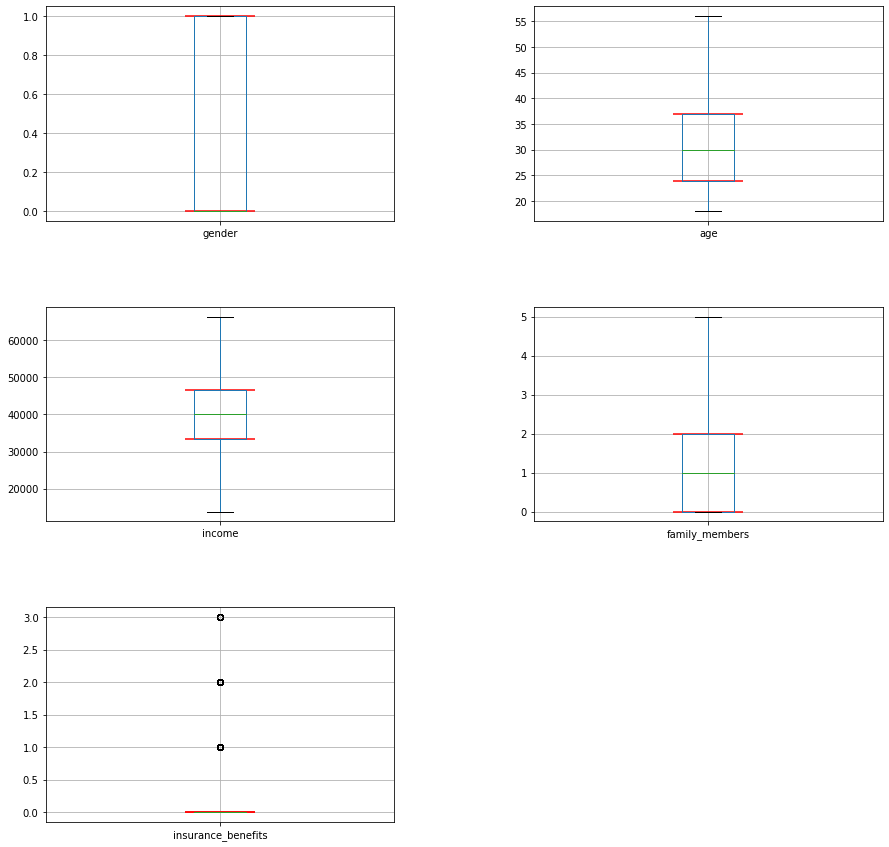

In [15]:
outlier_removal(df_outliers, df)

The outliers removal was done successfully. 

As we suspected, the removal of outliers in all the features except the target variable, removed also some of the target variable's outliers. Now we have clean features without outliers, and a target variable with some extreme values (1, 2 and 3), which are exactly what we want to predict (if all customers had 0 insurance benefits, we wouldn't have anything to predict).

**Duplicates**

In [16]:
# Checking for duplicates
df.duplicated().sum()

153

In [17]:
# Deleting duplicate rows
df.drop_duplicates(inplace = True)

# Verifying the duplicate removal was done correctly
df.duplicated().sum()

0

**Missing values**

In [18]:
df.stb.missing(style = True)

,missing,total,percent
gender,0,"4,788",0.00%
age,0,"4,788",0.00%
income,0,"4,788",0.00%
family_members,0,"4,788",0.00%
insurance_benefits,0,"4,788",0.00%


In [19]:
# Resetting the indices after removing the outliers and duplicates
df.reset_index(inplace = True, drop = True)

**Summary**

We checked the distribution of the features and removed their outliers. We discovered that all variables, including the target variable, have outliers. We decided to delete all the features outliers, but leave the target variable as it is. The removal of feature outliers removed some of the target variable outliers also. Also, we found duplicates and deleted them. In the end, we reset the indices of the data frame to keep all the records in order. Now we have a clean, free of missing values, outliers, and duplicated dataset. 

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

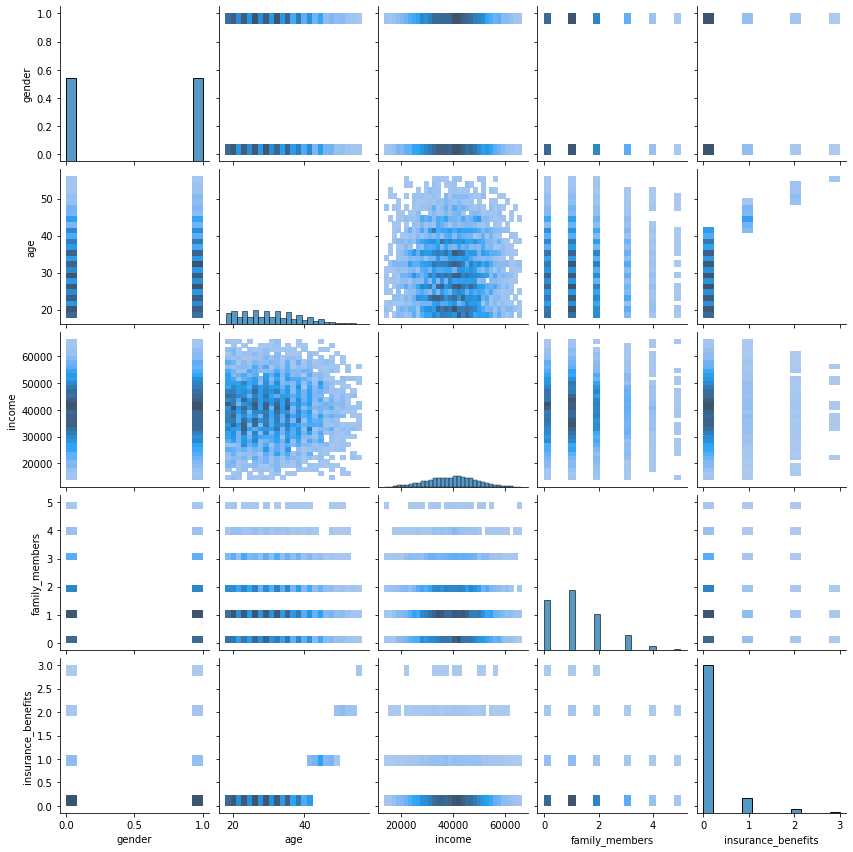

In [20]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [21]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [22]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors = k, metric = metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return  df_res

Scaling the data.

In [23]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [24]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2939,0.0,0.375000,0.683258,0.0,0
3062,0.0,0.607143,0.689291,0.0,0
1838,0.0,0.464286,0.687783,0.0,0
4080,0.0,0.732143,0.779789,0.6,0
1399,0.0,0.642857,0.366516,0.0,0


Now, let's get similar records for a given one for every combination

We will receive records for the customer documented in the dataset as index 23.

**Not Scaled Data + Euclidean Distance**

In [25]:
not_scaled_euclidean = get_knn(df[feature_names], 23, 15, 'euclidean')
not_scaled_euclidean

,gender,age,income,family_members,distance
23,0,33,48700.0,2,0.000000
1798,0,33,48700.0,1,1.000000
2741,0,32,48700.0,2,1.000000
2114,1,32,48700.0,1,1.732051
272,0,35,48700.0,1,2.236068
4252,1,36,48700.0,1,3.316625
845,1,38,48700.0,0,5.477226
1935,0,27,48700.0,0,6.324555
1907,0,26,48700.0,2,7.000000
4548,1,25,48700.0,2,8.062258


**Not Scaled Data + Manhatten Distance**

In [26]:
not_scaled_manhattan = get_knn(df[feature_names], 23, 15, 'manhattan')
not_scaled_manhattan

,gender,age,income,family_members,distance
23,0,33,48700.0,2,0.0
1798,0,33,48700.0,1,1.0
2741,0,32,48700.0,2,1.0
272,0,35,48700.0,1,3.0
2114,1,32,48700.0,1,3.0
4252,1,36,48700.0,1,5.0
1907,0,26,48700.0,2,7.0
845,1,38,48700.0,0,8.0
1935,0,27,48700.0,0,8.0
4548,1,25,48700.0,2,9.0


**Scaled Data + Euclidean Distance**

In [27]:
scaled_euclidean = get_knn(df_scaled[feature_names], 23, 15, 'euclidean')
scaled_euclidean

,gender,age,income,family_members,distance
23,0.0,0.589286,0.734540,0.4,0.000000
2741,0.0,0.571429,0.734540,0.4,0.017857
3334,0.0,0.589286,0.754148,0.4,0.019608
2898,0.0,0.571429,0.714932,0.4,0.026521
2483,0.0,0.589286,0.763198,0.4,0.028658
402,0.0,0.607143,0.758673,0.4,0.030021
1610,0.0,0.607143,0.705882,0.4,0.033766
1349,0.0,0.625000,0.740573,0.4,0.036220
2059,0.0,0.625000,0.749623,0.4,0.038769
1485,0.0,0.607143,0.698341,0.4,0.040364


**Scaled Data + Manhatten Distance**

In [28]:
scaled_manhattan = get_knn(df_scaled[feature_names], 23, 15, 'manhattan')
scaled_manhattan

,gender,age,income,family_members,distance
23,0.0,0.589286,0.734540,0.4,0.000000
2741,0.0,0.571429,0.734540,0.4,0.017857
3334,0.0,0.589286,0.754148,0.4,0.019608
2483,0.0,0.589286,0.763198,0.4,0.028658
2898,0.0,0.571429,0.714932,0.4,0.037465
1349,0.0,0.625000,0.740573,0.4,0.041747
402,0.0,0.607143,0.758673,0.4,0.041990
1610,0.0,0.607143,0.705882,0.4,0.046515
2059,0.0,0.625000,0.749623,0.4,0.050797
1485,0.0,0.607143,0.698341,0.4,0.054056


In [29]:
distance_df = pd.DataFrame({'not_scaled_euclidean': not_scaled_euclidean['distance'].reset_index(drop = True),
                           'not_scaled_manhattan': not_scaled_manhattan['distance'].reset_index(drop = True),
                           'scaled_euclidean': scaled_euclidean['distance'].reset_index(drop = True),
                           'scaled_manhattan': scaled_manhattan['distance'].reset_index(drop = True)})

In [30]:
distance_df

,not_scaled_euclidean,not_scaled_manhattan,scaled_euclidean,scaled_manhattan
0,0.000000,0.0,0.000000,0.000000
1,1.000000,1.0,0.017857,0.017857
2,1.000000,1.0,0.019608,0.019608
3,1.732051,3.0,0.026521,0.028658
4,2.236068,3.0,0.028658,0.037465
5,3.316625,5.0,0.030021,0.041747
6,5.477226,7.0,0.033766,0.041990
7,6.324555,8.0,0.036220,0.046515
8,7.000000,8.0,0.038769,0.050797
9,8.062258,9.0,0.040364,0.054056


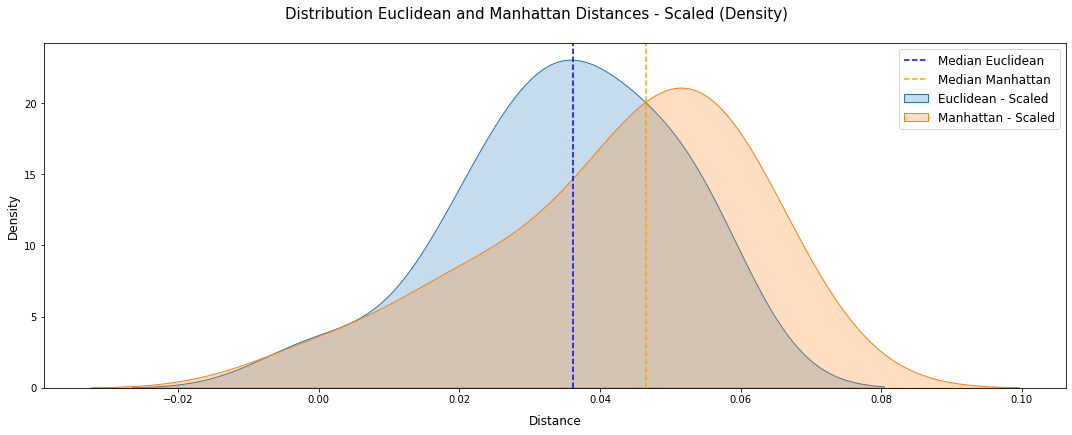

In [31]:
# Building a plot to compare the euclidean and manhattan metrics in the scaled datasets
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Distribution Euclidean and Manhattan Distances - Scaled (Density)', fontsize=15, y=1)

sns.kdeplot(distance_df['scaled_euclidean'], fill=True, label='Euclidean - Scaled')
sns.kdeplot(distance_df['scaled_manhattan'], fill=True, label='Manhattan - Scaled')
plt.axvline(x = distance_df['scaled_euclidean'].median(),
            color='blue',
            ls='--', 
            lw=1.5,
            label= 'Median Euclidean')
plt.axvline(x = distance_df['scaled_manhattan'].median(),
            color='orange',
            ls='--', 
            lw=1.5,
            label= 'Median Manhattan')
plt.legend(fontsize=12)
plt.xlabel('Distance', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
    
plt.tight_layout()
plt.show()

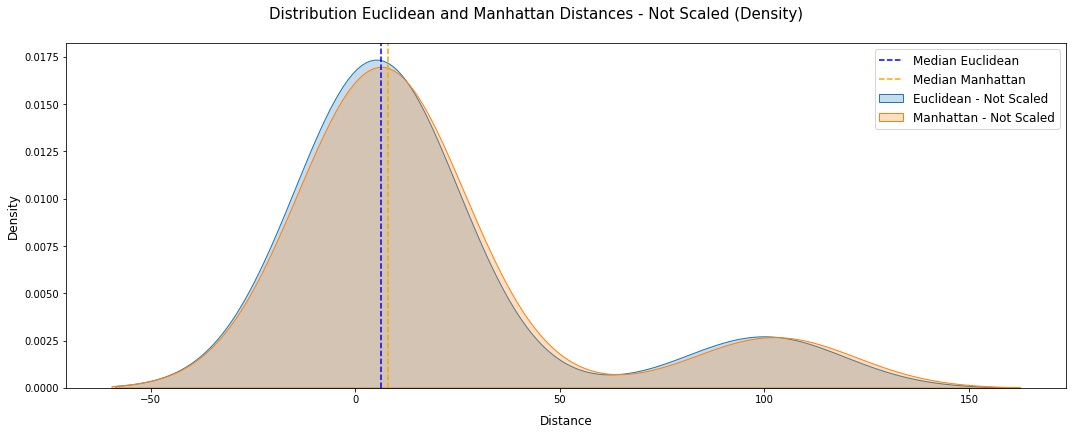

In [32]:
# Building a plot to compare the euclidean and manhattan metrics in the not scaled datasets
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Distribution Euclidean and Manhattan Distances - Not Scaled (Density)', fontsize=15, y=1)

sns.kdeplot(distance_df['not_scaled_euclidean'], fill=True, label='Euclidean - Not Scaled')
sns.kdeplot(distance_df['not_scaled_manhattan'], fill=True, label='Manhattan - Not Scaled')
plt.axvline(x = distance_df['not_scaled_euclidean'].median(),
            color='blue',
            ls='--', 
            lw=1.5,
            label= 'Median Euclidean')
plt.axvline(x = distance_df['not_scaled_manhattan'].median(),
            color='orange',
            ls='--', 
            lw=1.5,
            label= 'Median Manhattan')
plt.legend(fontsize=12)
plt.xlabel('Distance', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
    
plt.tight_layout()
plt.show()

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The answer is yes. This is because the KNN algorithm is a model that is affected by distance, so not scaled data that have for example numeric a feature with a large number range (for example income), will have a negative effect on the algorithm and may cause it to think that this feature is more important than others. We see that in the non-scaled data, the distances vary, and their range can be from zero to 100, which is a very high and significant difference. We can see in the plot that the non-scaled data has outliers, that implements the big range of the distances.
In the scaled dataset, the distances are very small, and they are all between the range of 0 and 1. It means that the distances are gathered around one unit of distance (0-1) - it can be seen clearly in the plot. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

For the not scaled data, the results for both metrics are the same. This is not the case in the scaled data. For the scaled dataset, the euclidean metric gave better results - it has smaller distances than the manhattan metric. 
So we can say that for the not scaled dataset, there was no difference using the manhattan or the euclidean metrics, but in the scaled dataset, the manhattan metric resulted in less good results.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [33]:
# calculate the target
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, 1, 0)
df_scaled['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits'] > 0, 1, 0)

In [34]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts() / len(df)

0    0.885965
1    0.114035
Name: insurance_benefits_received, dtype: float64

<div class="alert alert-info">
    
Splitting the data to train test set
</div>

In [35]:
# Splitting the data to train test sets
train_df_dummy, test_df_dummy = train_test_split(df, test_size = 0.3)
train_df_dummy_scaled, test_df_dummy_scaled = train_test_split(df_scaled, test_size = 0.3)

In [36]:
# Setting the features and the target varaibles for the non-scaled dataset
# train
features_train_duumy_ns = train_df_dummy.drop(['insurance_benefits', 'insurance_benefits_received'], axis = 1)
target_train_dummy_ns = train_df_dummy['insurance_benefits_received']
# test
features_test_duumy_ns = test_df_dummy.drop(['insurance_benefits', 'insurance_benefits_received'], axis = 1)
target_test_dummy_ns = test_df_dummy['insurance_benefits_received']

# Setting the features and the target varaibles for the scaled dataset
# train
features_train_duumy_s = train_df_dummy_scaled.drop(['insurance_benefits', 'insurance_benefits_received'], axis = 1)
target_train_dummy_s = train_df_dummy_scaled['insurance_benefits_received']
# test
features_test_duumy_s = test_df_dummy_scaled.drop(['insurance_benefits', 'insurance_benefits_received'], axis = 1)
target_test_dummy_s = test_df_dummy_scaled['insurance_benefits_received']

In [37]:
# Building an upsample() fucntion 
def upsample (features, target):
    
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target==1]
    
    repeat = int(len(target_zero) / len(target_one) )
    
    features_upsampled = pd.concat([features_zero] + [features_one]*repeat)
    target_upsampled = pd.concat([target_zero] + [target_one]*repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

# Calling the function for the not-scaled and scaled datasets
features_train_duumy_ns, target_train_dummy_ns = upsample(features_train_duumy_ns, target_train_dummy_ns)
features_train_duumy_s, target_train_dummy_s = upsample(features_train_duumy_s, target_train_dummy_s)

In [38]:
# Setting lists for f1_scores and probabilities
f1 = []
proba = []

In [39]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    f1.append(f1_score)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)
    print('==========================')
    print()

In [40]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):
    proba.append(P)

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [41]:
for P in [0, target_train_dummy_ns.sum() / len(target_train_dummy_ns), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size = len(target_test_dummy_ns)) 
        
    eval_classifier(target_test_dummy_ns, y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88239388 0.        ]
 [0.11760612 0.        ]]


The probability: 0.47
F1: 0.21
Confusion Matrix
[[0.47529576 0.40709812]
 [0.05636743 0.06123869]]


The probability: 0.50
F1: 0.21
Confusion Matrix
[[0.45163535 0.43075852]
 [0.05427975 0.06332637]]


The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88239388]
 [0.         0.11760612]]




In [42]:
f1_proba = pd.DataFrame(f1, index = np.round(proba,2), columns = ['f1_score'])
f1_proba

,f1_score
0.00,0.000000
0.47,0.209026
0.50,0.207053
1.00,0.210461


In [43]:
# Building KNN algorithm
def knn (k, features, target):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(features, target)
    return neigh

In [44]:
# Setting lists for k neighbors and f1_sscores
k = []
f1 = []
# Testing the algorithm for the not scaled data
for i in range(1,11):
    k.append(i)
    print('K=', i)
    knn_trained_model = knn(i, features_train_duumy_ns, target_train_dummy_ns)
    knn_test_prediction = knn_trained_model.predict(features_test_duumy_ns)
    f1_score = eval_classifier(target_test_dummy_ns, knn_test_prediction)

K= 1
F1: 0.68
Confusion Matrix
[[0.8670842  0.01530967]
 [0.04940849 0.06819763]]

K= 2
F1: 0.68
Confusion Matrix
[[0.8670842  0.01530967]
 [0.04940849 0.06819763]]

K= 3
F1: 0.63
Confusion Matrix
[[0.84203201 0.04036186]
 [0.04453723 0.07306889]]

K= 4
F1: 0.63
Confusion Matrix
[[0.84272791 0.03966597]
 [0.04523312 0.072373  ]]

K= 5
F1: 0.56
Confusion Matrix
[[0.80375783 0.07863605]
 [0.04036186 0.07724426]]

K= 6
F1: 0.57
Confusion Matrix
[[0.80445372 0.07794015]
 [0.04036186 0.07724426]]

K= 7
F1: 0.50
Confusion Matrix
[[0.76339596 0.11899791]
 [0.03827418 0.07933194]]

K= 8
F1: 0.50
Confusion Matrix
[[0.76409186 0.11830202]
 [0.03827418 0.07933194]]

K= 9
F1: 0.47
Confusion Matrix
[[0.73208072 0.15031315]
 [0.0361865  0.08141962]]

K= 10
F1: 0.47
Confusion Matrix
[[0.73347251 0.14892136]
 [0.0361865  0.08141962]]



In [45]:
test_k_f1 = pd.DataFrame(f1, index=k, columns=['f1_score_not_scaled'])

In [46]:
# Setting lists for k neighbors and f1_sscores
k = []
f1 = []
# Testing the algorithm for the scaled data
for i in range(1,11):
    k.append(i)
    print('K=', i)
    knn_trained_model = knn(i, features_train_duumy_s, target_train_dummy_s)
    knn_test_prediction = knn_trained_model.predict(features_test_duumy_s)
    f1_score = eval_classifier(target_test_dummy_s, knn_test_prediction)

K= 1
F1: 0.94
Confusion Matrix
[[0.88378566 0.00417537]
 [0.00835073 0.10368824]]

K= 2
F1: 0.94
Confusion Matrix
[[0.88378566 0.00417537]
 [0.00835073 0.10368824]]

K= 3
F1: 0.94
Confusion Matrix
[[0.87821851 0.00974252]
 [0.00417537 0.1078636 ]]

K= 4
F1: 0.94
Confusion Matrix
[[0.87821851 0.00974252]
 [0.00417537 0.1078636 ]]

K= 5
F1: 0.92
Confusion Matrix
[[0.86917189 0.01878914]
 [0.00139179 0.11064718]]

K= 6
F1: 0.92
Confusion Matrix
[[0.86917189 0.01878914]
 [0.00139179 0.11064718]]

K= 7
F1: 0.89
Confusion Matrix
[[8.62212944e-01 2.57480863e-02]
 [6.95894224e-04 1.11343076e-01]]

K= 8
F1: 0.89
Confusion Matrix
[[8.62212944e-01 2.57480863e-02]
 [6.95894224e-04 1.11343076e-01]]

K= 9
F1: 0.88
Confusion Matrix
[[8.57341684e-01 3.06193459e-02]
 [6.95894224e-04 1.11343076e-01]]

K= 10
F1: 0.88
Confusion Matrix
[[8.57341684e-01 3.06193459e-02]
 [6.95894224e-04 1.11343076e-01]]



In [47]:
test_k_f1_scaled = pd.DataFrame(f1, index=k, columns=['f1_score_scaled'])

In [48]:
# Building dictionary combining all the f1_scores for creating a DataFrame
f1_scores = { 'f1_score_test_not_scaled': test_k_f1['f1_score_not_scaled'], 'f1_score_test_scaled':test_k_f1_scaled['f1_score_scaled']}

# Building DataFrame that compares all the the results
scores_df = pd.DataFrame(f1_scores, index = k)
scores_df

,f1_score_test_not_scaled,f1_score_test_scaled
1,0.678201,0.943038
2,0.678201,0.943038
3,0.632530,0.939394
4,0.630303,0.939394
5,0.564885,0.916427
6,0.566327,0.916427
7,0.502203,0.893855
8,0.503311,0.893855
9,0.466135,0.876712
10,0.468000,0.876712


In [49]:
f1_proba

,f1_score
0.00,0.000000
0.47,0.209026
0.50,0.207053
1.00,0.210461


As we can see in the 2 tables above summarize our experiments. We see that:
1. The KNN algorithm gives much better scores than the dummy model. 

2. The F1 score for the scaled dataset is much better than for the non-scaled dataset.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [50]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.w0 = weights[0]

    def predict(self, X):
        
        # adding the unities
        X2 = X
        y_pred = X2.dot(self.weights) + self.w0
        
        return y_pred

In [51]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [52]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.22643521e-02  1.15938772e-02 -1.36697114e-07 -1.41138076e-02]
RMSE: 0.34
R2: 0.67


In [53]:
# Checking the RMSE for the scaled dataset
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.80680372  0.01159388 -0.00906302 -0.07056904]
RMSE: 0.34
R2: 0.67


We can see that there is no difference in the RMSE score for the 2 cases of scaled and not scaled datasets.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

In [54]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [55]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [56]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [57]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can you guess the customers' ages or income after the transformation?

In [58]:
x_tag = X @ P

In [59]:
df_obfus = pd.DataFrame(x_tag, columns = personal_info_column_list)
df_obfus.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


After transformation, it's impossible to guess the customers' age. The age feature has unrealistic values for age (like 22,380 years old). The income feature has realistic values, so maybe someone will think that it's impossible to guess the customer's actual income. But when looking at the whole dataset, it's clear that the dataset is obfuscated, including the income feature, so technically it's also impossible to guess the income variable although its realistic values - the obfuscating method is unknown to outsiders.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [60]:
x_revers = np.round(x_tag @ np.linalg.inv(P)).astype(int)

In [61]:
df_revers = pd.DataFrame(x_revers, columns = personal_info_column_list)

In [62]:
df_revers.head()

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0


In [63]:
df_pn.head()

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [64]:
# Setting a group of customers
customers = range(15,26)

In [65]:
df_pn.loc[customers]

,gender,age,income,family_members
15,1,34,23300.0,0
16,1,26,48900.0,2
17,1,41,33200.0,2
18,1,42,49700.0,0
19,1,27,36900.0,0
20,1,38,43500.0,1
21,1,36,36100.0,1
22,0,41,26600.0,0
23,0,33,48700.0,2
24,0,21,40400.0,3


In [66]:
df_obfus.loc[customers]

,gender,age,income,family_members
15,2989.023627,10527.602391,8666.331312,21621.047795
16,6269.266935,22051.322946,18153.558444,45340.397472
17,4259.295562,14994.898056,12343.446559,30801.978112
18,6371.976949,22425.596131,18461.488270,46093.932015
19,4730.709790,16646.021790,13703.856464,34219.549193
20,5577.939582,19630.123588,16159.939375,40345.072065
21,4629.710345,16295.316403,13414.511716,33485.439019
22,3411.683900,12020.266464,9894.434172,24684.177340
23,6243.529494,21967.636236,18083.868219,45159.849556
24,5179.700080,18218.548245,14997.554355,37458.494616


In [67]:
df_revers.loc[customers]

,gender,age,income,family_members
15,1,34,23300,0
16,1,26,48900,2
17,1,41,33200,2
18,1,42,49700,0
19,1,27,36900,0
20,1,38,43500,1
21,1,36,36100,1
22,0,41,26600,0
23,0,33,48700,2
24,0,21,40400,3


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Well, we see here that the data in the obfuscated dataset is different, and it's because we transformed it by multiplication with an inverse matrix. The other 2 datasets, the original and the reversed are the same.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

No code is necessary in this section, only analytical explanation!

**Answer**

Simplifying the formule of $w_p$ outcomes:
$$
w_P = P^{-1} (X^TX)^{-1} X^T y
$$
(The full calculation can be seen in the analytical proof beneath)

While the formula of $w$ is:
$$
w = (X^T X)^{-1} X^T y
$$

We can see that the 2 weights are linked with the invertive matrix of $P$. Because the values are being obfuscated with matrix $P$, when calculating the prediction $\hat{y}$, we actually multiplying the matrix $P$ with its inverse matrix $p^{-1}$, which results in the unit matrix $I$. So, basically, we are left with the same values $X{val}$, $(X^T X)^{-1}$, $X^T$ and $y$, just like in the original formula for the original data.

Regarding the RMSE metric, the results will not change, because we have the same predictions (and we didn't obfuscate the target variable so they also stayed the same). The variables that the RMSE metric is calculated by them (the predictions and the target variable) didn't change, so the RMSE metric also wouldn't change. This is good because this means that we can obfuscate our data without worrying, because the linear regression algorithm will continue to give accurate predictions, regardless of the obfuscation.

**Analytical proof**

First, let's simplify the wights $w_p$:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$
$$
w_P = [(XP)^T XP]^{-1} P^T X^T y
$$
$$
w_P = [(P^T X^T XP]^{-1} P^T X^T y
$$
$$
w_P = P^{-1} (X^TX)^{-1} (P^T)^{-1} P^T X^T y
$$
$$
w_P = P^{-1} (X^TX)^{-1} I X^T y
$$
$$
w_P = P^{-1} (X^TX)^{-1} X^T y
$$

We know that:
$$
\hat{y} = X_{val}w
$$

So, if we will place in the formula wights $w$ we will get: 
$$
\hat{y} = X_{val}(X^T X)^{-1} X^T y
$$

Now we will place in the formula the simplified weights $w_p$ and the obfuscated values, and see what will be the result:
$$
\hat{y} = X_{val} P P^{-1} (X^TX)^{-1} X^T y
$$
$$
\hat{y} = X_{val} I (X^TX)^{-1} X^T y
$$
$$
\hat{y} = X_{val} (X^TX)^{-1} X^T y
$$

We got the same predictions for the original data and the obfuscated data.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Building a function of Linear Regression Model that check if it can work computationally with the original and the obfuscated data.
- Use $XP$ as the new feature matrix

In [68]:
def regression(features_train, target_train, features_test, target_test):
    lr = LinearRegression()
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_test)
    rmse = math.sqrt(mean_squared_error(target_test, predictions))
    r2 = math.sqrt(r2_score(target_test, predictions))
    print('RMSE:', rmse)
    print()
    print('R2:', r2)
    return predictions[:10]

In [69]:
# Creating square matrix 𝑃 of random numbers
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [70]:
#Checking the matrix 𝑃 is invertible
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [71]:
# Setting the obfuscated dataset
x_obfus = X @ P
obfus = pd.DataFrame(x_obfus, columns = personal_info_column_list)
df_obfus = pd.concat([obfus, df['insurance_benefits']], axis = 1)

In [72]:
df_obfus.head(3)

,gender,age,income,family_members,insurance_benefits
0,6359.715273,22380.404676,18424.090742,46000.696690,0
1,4873.294065,17160.367030,14125.780761,35253.455773,1
2,2693.117429,9486.397744,7808.831560,19484.860631,0


In [73]:
# Splitting the original and the obfuscared datasets to train and test sets

# original dataset
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 12345)

# obfuscated dataset
train_df_obfus, test_df_obfus = train_test_split(df_obfus, test_size = 0.3, random_state = 12345)

In [74]:
# Setting the features and target variables for the original dataset

# train
features_train_original = train_df[personal_info_column_list]
traget_train_original = train_df['insurance_benefits']
# test
features_test_original = test_df[personal_info_column_list]
traget_test_original = test_df['insurance_benefits']

# Setting the features and target variables for the obfuscated dataset

# train
features_train_obfus = train_df_obfus[personal_info_column_list]
traget_train_obfus = train_df_obfus['insurance_benefits']
# test
features_test_obfus = test_df_obfus[personal_info_column_list]
traget_test_obfus = test_df_obfus['insurance_benefits']

In [75]:
# Using the Linear Regression function on the original data
regression(features_train_original, traget_train_original, features_test_original, traget_test_original)

RMSE: 0.34161778344485255

R2: 0.6690789238938006


array([-0.1270786 ,  0.21605769, -0.21026363, -0.25350672,  0.61133384,
       -0.22840051, -0.19614982,  0.38485457,  0.15259522, -0.11710034])

In [76]:
# Using the Linear Regression function on the obfuscated data
regression(features_train_obfus, traget_train_obfus, features_test_obfus, traget_test_obfus)

RMSE: 0.3416177834448624

R2: 0.6690789238937768


array([-0.1270786 ,  0.21605769, -0.21026363, -0.25350672,  0.61133384,
       -0.22840051, -0.19614982,  0.38485457,  0.15259522, -0.11710034])

As we can see above, all the values are the same.

# Conclusions

1. At the beginning of this project we checked the quality of data. We looked after missing values, outliers and duplicates. **We didn't find missing values, but we did find outliers and duplicates, so we removed them**, and then reset the dataset's indices, to maintain order, and not to damage further commands that are index dependent.


2. **Scaling the data had big influence on the KNN algorithm**. When scaling the data, the distances between the neighbors decreases to one distance unit (meaning between 0 and 1). On the contrary, when not scaling the data, the distance between the neighbors can vary from 23 to 103 for example.


3. **The Manhattan and the Euclidean distance metrics had almost the same results for the non-scaled dataset**. On the other hand, **with scaled data, the Euclidean distance metric returned shorter distances than the Manhattan distance metric - about 20% shorter**. 


4. **The KNN prediction outcomes are influenced by scaled data**. The algorithm performs much better with scaled data than with non-scaled data.


5. **Increasing the number of neighbors brings lower prediction performance**. As the number of neighbors rises, the algorithm predictions are getting less accurate. **It is important to mention that here also, scaling the data has a positive influence**. With scaled data, **the decrease of the KNN algorithm performance is about 5%.** While with not-scaled data, **the decrease of the KNN algorithm performance is about 15%**.



6. The data's transformation with random invertive matrix $P$, obfuscated the data quey well for outdoor people. **Its impossible for outsider agents that don't know the encryption key, to guess the real data of the customers**. The data of course is recoverable for the ones that know the encryption key - in our case multiplying the original data with a random invertible matrix $P$. 


7. We proved mathematically and demonstrated, that although transforming the original dataset, Linear Regression model returns almost the same predictions for both the original data and the obfuscated data. This is a really helpful feature because we can obfuscate and secure personal data without worrying that the model's performance will damage.